#  library

main() 함수 내 crawler() 함수 수행

In [1]:
 # -*- coding: utf-8 -*-
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""
fname = '한국행정구역분류_2022.1.1.기준.xlsx'
data_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})
data_region[1].drop('Unnamed: 0', axis=1, inplace=True)
data_citydo_all = data_region[1]['시도'][1:]
data_citydo_unique = data_citydo_all.unique()
booleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]
data_citydo_unique_notna = data_citydo_unique[booleanArray1]
data_citydo_unique_notna
data_citygungu_all = data_region[1]['시군구'][1:]
data_citygungu_unique = data_citygungu_all.unique()
data_citygungu_unique
"""

"\nfname = '한국행정구역분류_2022.1.1.기준.xlsx'\ndata_region = pd.read_excel(fname, sheet_name = [1], skiprows=2, dtype={'대분류':str, '중분류':str, '소분류':str})\ndata_region[1].drop('Unnamed: 0', axis=1, inplace=True)\ndata_citydo_all = data_region[1]['시도'][1:]\ndata_citydo_unique = data_citydo_all.unique()\nbooleanArray1 = [not pd.isnull(number) for number in data_citydo_unique]\ndata_citydo_unique_notna = data_citydo_unique[booleanArray1]\ndata_citydo_unique_notna\ndata_citygungu_all = data_region[1]['시군구'][1:]\ndata_citygungu_unique = data_citygungu_all.unique()\ndata_citygungu_unique\n"

# 크롤링

- 크롤링 해오는 것 : 링크,제목,신문사,내용요약본
- 키워드 : 붉은물, 적수, 유충


- 내용요약본  -> 정제 작업 필요
- 리스트 -> 딕셔너리 -> df -> 엑셀로 저장

In [2]:
cos = []

In [104]:
flag_save = 0

maxpage = input("최대 크롤링할 페이지 수 입력하시오: ")  # 1
sort = input("뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): ") # 0

s_date = '2019.08.08' # 2019.05.10  2019.05.20  2019.05.30  2019.06.09  2019.06.19  2019.06.29  2019.07.09  2019.07.19  2019.07.29  2019.08.08
e_date = '2019.08.17' # 2019.05.19  2019.05.29  2019.06.08  2019.06.18  2019.06.28  2019.07.08  2019.07.18  2019.07.28  2019.08.07  2019.08.17

#각 크롤링 결과 저장하기 위한 리스트 선언
title_text=[]
link_text=[]
source_text=[]
contents_text=[]
result={}

#엑셀로 저장하기 위한 변수
#RESULT_PATH ='C:/'  #결과 저장할 경로
now = datetime.now() #파일이름 현 시간으로 저장하기

#내용 정제화 함수
def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '',str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)

#크롤링 시작
list_region = ['인천']

for region in list_region:
  list_keyword = ['유충']
  for keyword in list_keyword:
    query = region +' ' + keyword
    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지
    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        response = requests.get(url)
        html = response.text

        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(html, 'html.parser')

        #<a>태그에서 제목과 링크주소 (a 태그 중 class 명이 news_tit인 것)
        atags = soup.find_all('a', 'news_tit')
        for atag in atags:
            title = atag.get('title')
            title_text.append(title)     #제목
            link_text.append(atag['href'])   #링크주소

        #신문사 추출 (a 태그 중 class 명이 info press인 것)
        source_lists = soup.find_all('a', 'info press')
        for source_list in source_lists:
            source_text.append(source_list.text)    #신문사

        #본문요약본 (a 태그 중 class 명이 api_txt_lines dsc_txt_wrap인 것)
        contents_lists = soup.find_all('a','api_txt_lines dsc_txt_wrap')
        for contents_list in contents_lists:
            contents_cleansing(contents_list) #본문요약 정제화

        #모든 리스트 딕셔너리형태로 저장
        result= {"title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }
        df = pd.DataFrame(result)  #df로 변환
        page += 10
        print(df)

if flag_save == 1:
    # 새로 만들 파일이름 지정
    outputFileName = '%s-%s-%s %s시 %s분 %s초 merging' % (now.year, now.month, now.day, now.hour, now.minute, now.second)
    df.to_excel(outputFileName+'.xlsx',sheet_name='sheet1')
    #df.to_csv(outputFileName+'.csv', mode='w')

최대 크롤링할 페이지 수 입력하시오: 1
뉴스 검색 방식 입력(관련도순=0  최신순=1  오래된순=2): 0
                           title source  \
0        인천시 남동구, 장마철 방역소독 활동 실시   기호일보   
1  인천 남동구, 장마 후 모기억제 위한 방역 활동 총력  메트로신문   

                                            contents  \
0  기호일보, KIHOILBO 인천시 남동구는 집중호우와 무더위로 인한 감염병 발생을 ...   
1  남동구, 장마 후 모기억제 위한 방역 활동 총력 인천 남동구(구청장 이강호)는 장마...   

                                                link  
0  http://www.kihoilbo.co.kr/?mod=news&act=articl...  
1  http://www.metroseoul.co.kr/news/newsview?news...  


In [105]:
list_search = ' '.join(list_region) + ' ' + ' '.join(list_keyword)
dfNew = pd.Series(list_search)
df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)

corpus = df_tfidf_base
corpus

C:\Users\qpflw\AppData\Local\Temp/ipykernel_27364/123471369.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tfidf_base = df['contents'].append(dfNew,ignore_index=True)


0    기호일보, KIHOILBO 인천시 남동구는 집중호우와 무더위로 인한 감염병 발생을 ...
1    남동구, 장마 후 모기억제 위한 방역 활동 총력 인천 남동구(구청장 이강호)는 장마...
2                                                인천 유충
dtype: object

In [106]:
df

,title,source,contents,link
0,"인천시 남동구, 장마철 방역소독 활동 실시",기호일보,"기호일보, KIHOILBO 인천시 남동구는 집중호우와 무더위로 인한 감염병 발생을 ...",http://www.kihoilbo.co.kr/?mod=news&act=articl...
1,"인천 남동구, 장마 후 모기억제 위한 방역 활동 총력",메트로신문,"남동구, 장마 후 모기억제 위한 방역 활동 총력 인천 남동구(구청장 이강호)는 장마...",http://www.metroseoul.co.kr/news/newsview?news...


# 벡터화

In [107]:
tfidfv = TfidfVectorizer().fit(corpus)
tfidfv_array = tfidfv.transform(corpus).toarray()

In [108]:
tfidfv_array

array([[0.18709413, 0.18709413, 0.        , 0.14228991, 0.18709413,
        0.        , 0.14228991, 0.14228991, 0.18709413, 0.        ,
        0.18709413, 0.18709413, 0.        , 0.18709413, 0.14228991,
        0.18709413, 0.18709413, 0.        , 0.        , 0.14228991,
        0.14228991, 0.        , 0.18709413, 0.        , 0.18709413,
        0.        , 0.18709413, 0.14228991, 0.14228991, 0.        ,
        0.14228991, 0.18709413, 0.        , 0.18709413, 0.        ,
        0.14228991, 0.        , 0.        , 0.        , 0.18709413,
        0.14228991, 0.14228991, 0.14228991, 0.        , 0.18709413,
        0.14228991, 0.14228991, 0.14228991, 0.        , 0.14228991,
        0.14228991, 0.14228991, 0.        , 0.18709413, 0.14228991],
       [0.        , 0.        , 0.17918273, 0.13627309, 0.        ,
        0.17918273, 0.13627309, 0.13627309, 0.        , 0.17918273,
        0.        , 0.        , 0.35836546, 0.        , 0.13627309,
        0.        , 0.        , 0.17918273, 0.1

# 유사도

In [109]:
cos_sim_df = pd.DataFrame(cosine_similarity(tfidfv_array, tfidfv_array)) 
cos_sim_df

,0,1,2
0,1.000000,0.387806,0.000000
1,0.387806,1.000000,0.082493
2,0.000000,0.082493,1.000000


In [110]:
len_contents = len(cos_sim_df)-1
len_contents

2

In [111]:
cos_sim_df_sorted = cos_sim_df.iloc[len_contents].sort_values(ascending=False)
cos_sim_df_sorted

2    1.000000
1    0.082493
0    0.000000
Name: 2, dtype: float64

In [112]:
cos_sim_df_sorted_others = cos_sim_df_sorted[1:]
cos_sim_df_sorted_others

cos_sim_df_sorted_others_sum = cos_sim_df_sorted_others.sum()/10 * 100 # percent 지표
print(cos_sim_df_sorted_others_sum)

0.8249270893349829


In [113]:
cos.append(cos_sim_df_sorted_others_sum)
cos

[0.6922450137975561,
 3.8943174085198122,
 3.3462950762355455,
 9.177497269169354,
 4.374857818953829,
 3.527009995595795,
 0.7612145218879015,
 5.657609186710974,
 1.5342553542521657,
 0.8249270893349829]

In [114]:
cos_df = pd.DataFrame(cos)
cos_df

,0
0,0.692245
1,3.894317
2,3.346295
3,9.177497
4,4.374858
5,3.527010
6,0.761215
7,5.657609
8,1.534255
9,0.824927


# 시각화

In [115]:
plt.rc("font", family="Malgun Gothic") # window

Text(0.5, 1.0, '네이버 코사인 유사도(%)')

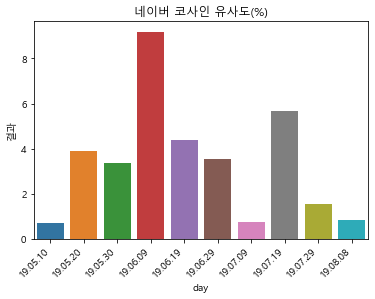

In [116]:
df1=pd.DataFrame({'day':('19.05.10','19.05.20','19.05.30','19.06.09','19.06.19','19.06.29', '19.07.09', '19.07.19', '19.07.29', '19.08.08'),'결과':cos})
p = sns.barplot(data = df1, x ='day',y='결과')
p.set_xticklabels(p.get_xticklabels(), rotation=45, horizontalalignment='right')
p.set_title("네이버 코사인 유사도(%)")

In [117]:
list_search = ' '.join(list_region) + ' ' + ' '.join(list_keyword)
list_search

'인천 유충'